#Packages

In [1]:
import numpy
from numpy.linalg import norm
from numpy import dot,array

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patches as patches

from pylab import show,imshow
import heapq
from math import *

#!pip install cvxopt
from cvxopt import matrix, solvers

import random

import os
import matplotlib.animation as animation

#Initialiser la géométrie

In [2]:
class GridGraph:

    global OBSTACLE
    global EXIT
    OBSTACLE = 0
    EXIT = 2

    def __init__(self,size_scene,precision):
        self.precision = precision
        self.horizontal_size = int(size_scene[0]*precision)+1
        self.vertical_size = int(size_scene[1]*precision)+1
        self.indicator_map = numpy.ones((self.vertical_size,self.horizontal_size))
        self.distances = numpy.ones((self.vertical_size,self.horizontal_size))*float('inf')

    def get_neighbours(self,node):
        result = {}
        if node[1]<self.horizontal_size-1:
            result['x+1']=(node[0],node[1]+1)
        if node[1]>0:
            result['x-1']=(node[0],node[1]-1)
        if node[0]<self.vertical_size-1:
            result['y+1']=(node[0]+1,node[1])
        if node[0]>0:
            result['y-1']=(node[0]-1,node[1])
        return result

    def to_node(self,coordinates):
        return (int(coordinates[1]*self.precision),int(coordinates[0]*self.precision))

    def prepare_graph_for_fast_marching(self,obstacles,exits,agentSize):

        for obstacle in obstacles:

            dl = (obstacle.position[0] , obstacle.position[1])

            ur = (obstacle.position[0] + obstacle.width , obstacle.position[1] + obstacle.height)

            for x in range(self.to_node(dl)[0]+1,self.to_node(ur)[0]):

                for y in range(self.to_node(dl)[1]+1,self.to_node(ur)[1]):

                    if x>=0 and x<self.indicator_map.shape[0] and y>=0 and y<self.indicator_map.shape[1]:
                      
                        self.indicator_map[x,y]=OBSTACLE

        for exit_ in exits:
            dl = (exit_.position[0],exit_.position[1])
            ur = (exit_.position[0]+exit_.width,exit_.position[1]+exit_.height)
            for x in range(self.to_node(dl)[0],self.to_node(ur)[0]+1):
                for y in range(self.to_node(dl)[1],self.to_node(ur)[1]+1):
                    if x>=0 and x<self.indicator_map.shape[0] and y>=0 and y<self.indicator_map.shape[1]:
                        self.indicator_map[x,y]=EXIT

In [3]:
def generate_indiv(N):

  a , b = size_scene
  espace_x , espace_y = 20 , 20

  #first agent
  x = random.randint(eps+espace_x,a-eps-espace_x)
  y = random.randint(eps+espace_y,b-eps-espace_y)
  L = [myAgent((x,y))]

  while len(L) < N:

    choc = False

    q = [agent.position for agent in L]
    R = [agent.size for agent in L]

    x = random.randint(eps+espace_x,a-eps-espace_x)
    y = random.randint(eps+espace_y,b-eps-espace_y)
    r = 4

    q.append([x,y])
    R.append(r)


    for j in range(len(q)-1):
      if dist(q[-1], q[j]) - (R[-1]+R[j]) <= 5:
        choc = True
        break

    if not choc:
      agent = myAgent((x,y))
      agent.size = r
      L.append(agent)
      
  return L

In [4]:
class PriorityQueue():


    def __init__(self):
        self.queue = []
        self.current = 0

    def pop(self):
        return heapq.heappop(self.queue)

    def remove(self, nodeId):
        for i in range(len(self.queue)):
            if self.queue[i][1]==nodeId:
                self.queue.pop(i)
                break;

    def __iter__(self):
        return self

    def __str__(self):
        return 'PQ:[%s]'%(', '.join([str(i) for i in self.queue]))

    def append(self, node):
        heapq.heappush(self.queue,node)

    def __contains__(self, key):
        self.current = 0
        return key in [n for _,n in self.queue]

    def __eq__(self, other):
        self.curent = 0
        return self == other

    def __getitem__(self, nodeId):
        for element in self.queue:
            if element[1]==nodeId:
                return element
        return None

    def clear(self):
        self.queue = []

    def __len__(self):
        return len(self.queue)

    __next__ = next


In [5]:
class Exit:
  
    def __init__(self,position,width,height):

        self.position = position
        self.width = width
        self.height = height

In [6]:
class Obstacle():

    def __init__(self, position,width,height):

        self.position=position
        self.width=width
        self.height=height
        
    def __repr__(self):
        return 'Obstacle'+'\n'+'DL:'+str(self.position)+'DR:'+str((self.position[0]+self.width,self.position[1]))+'UR:'+str((self.position[0]+self.width,self.position[1]+self.height))+'UL:'+str((self.position[0]+self.width,self.position[1]))

In [7]:
def draw(Ex, Obs, scene, agents):

  fig, ax = plt.subplots(figsize=(10,7))

  #Draw the environment
  L , l = scene
  plt.plot([0, L], [0, 0], 'black')
  plt.plot([L, L], [0, l], 'black')
  plt.plot([L, 0], [l,l], 'black')
  plt.plot([0,0], [l,0], 'black')
  
  #Draw Obstacle
  for obs in Obs:
    rect = Rectangle(obs.position, obs.width, obs.height)
    rect.set_color('black')
    ax.add_patch(rect)
  
  #Draw exits
  for e in Ex:
    rect = Rectangle(e.position, e.width, e.height)
    rect.set_color('red')
    ax.add_patch(rect)

  #Draw agents
  for agent in agents:
    x,y = agent.position
    circle = Circle((x,y), agent.size)
    circle.set_color(agent.color)
    ax.add_patch(circle)

  plt.show()

#Fast Marching

In [8]:
def fast_marching_method(graph,start):
  
    def calculus_distance(node,graph,weights):
        neighbours = graph.get_neighbours(node);
        if 'y-1' in neighbours :
            if 'y+1' in neighbours:
                x1 = min(weights[neighbours['y-1']],weights[neighbours['y+1']]);
            else :
                x1 = weights[neighbours['y-1']];
        else :
            if 'y+1' in neighbours:
                x1 = weights[neighbours['y+1']];
        if 'x-1' in neighbours:
            if 'x+1' in neighbours:
                x2 = min(weights[neighbours['x-1']],weights[neighbours['x+1']]);
            else :
                x2 = weights[neighbours['x-1']];
        else :
            if 'x+1' in neighbours:
                x2 = weights[neighbours['x+1']];
        
        if 2*h**2-(x1-x2)**2>=0:
            return (x1+x2+(2*h**2-(x1-x2)**2)**0.5)/2
        else:
            return min(x1,x2)+h
        
    
    frontier = PriorityQueue();
    weights = graph.distances;
    
    explored = []
    
    goals = numpy.where(graph.indicator_map==2)
    goals_x = goals[0]
    goals_y = goals[1]
    for i in range(goals_x.size):
        frontier.append([0,(goals_x[i],goals_y[i])])
        weights[(goals_x[i],goals_y[i])] = 0
    
       
    while frontier:
        node = frontier.pop();
        explored.append(node[1])
        neighbours = graph.get_neighbours(node[1]);
        for neighbour in neighbours.values():
            if neighbour not in explored and graph.indicator_map[neighbour]:
                if not neighbour in frontier:
                    frontier.append([calculus_distance(neighbour,graph,weights),neighbour])
                    weights[neighbour]=calculus_distance(neighbour,graph,weights)
                elif weights[neighbour] > calculus_distance(neighbour,graph,weights):
                    frontier[neighbour][0]=calculus_distance(neighbour,graph,weights)
                    weights[neighbour]=calculus_distance(neighbour,graph,weights)

    graph.distances = weights

#MyAgent

In [9]:
class myAgent():

  def __init__(self, position):
    self.position = position
    self.speed = (0,0)
    self.D_S = (1,0)
    self.size = 4
    self.has_reached_exit = False
    self.masse = 80
    self.color = 'red'


  def Voisins(self, agents):

    liste = []

    for agent in agents:
      if agent != self:
        if dist(agent.position, self.position)<3:
          liste.append(agent)

    return liste


  def update_D_S(self):

    x, y = self.position

    a, b = size_scene

    try :
      n , m = int(x/h) , int((b-y)/h)

      if n < 0:
        n = 0
      if m < 0:
        m = 0
      if n > len(FX[0])-1:
        n = len(FX[0])-1
      if m > len(FX)-1:
        m = len(FX)-1
      
      self.D_S = (FX[m][n], FY[m][n])

    except :
      return



  def update_Speed(self, v):

    self.speed = (v[0],v[1])


  def reach_exit(self):
    x, y = self.position
    r = self.size
    for exit in exits:
      [ex, ey], w = exit.position, exit.width
      if ex + r < x < ex + w -r and y + r >= ey:
        self.has_reached_exit = True


  def update_Position(self, q):

    self.position = q
    self.reach_exit()

#Fonctions

In [10]:
def dist(p1,p2):
    return norm(numpy.array(p1)-numpy.array(p2))

def distance_vecteur_obj(q1, q2, r1, r2):
    d = dist(q1, q2)

    n = -(numpy.array(q2) - numpy.array(q1))/d

    d = d - (r1 + r2)

    return d , n

def distance_vecteur_obs(q , r, obstacle):
    [a0, b0], L, l = obstacle.position, obstacle.width, obstacle.height
    a1, b1 = a0 + L , b0 + l
    x , y = q
    point = []

    if x<=a0:
      if y>=b1: #zone1
        point = [a0, b1]

      elif b0<y<b1: #zone2
        point = [a0, y]

      else: #zone3
        point = [a0, b0]

    elif a0<x<a1:
      if y>=b1: #zone4
        point = [x, b1]

      elif b0<y<b1: #zone5
        point = [0,0]
        print("zone 5")

      else: #zone6
        point = [x, b0]

    else:
      if y>=b1: #zone7
        point = [a1, b1]

      elif b0<y<b1: #zone8
        point = [a1, y]

      else: #zone9
        point = [a1, b0]
        
    d = dist(point , q)
    n = (numpy.array(q) - numpy.array(point))/d

    return d - r , n

In [11]:
def enFace(agent, agent2):

  n = -(numpy.array(agent.position) - numpy.array(agent2.position))
  v = numpy.array(agent.speed)

  n_ = n / numpy.linalg.norm(n)
  v_ = v / numpy.linalg.norm(v)
  dot_product = numpy.dot(n_, v_)
  angle = numpy.arccos(dot_product)

  x = dist(agent.position, agent2.position) - (agent.size + agent2.size)

  if abs(angle) < pi/2 and x <= 15:
    return True
  
  return False

In [12]:
#force motrice
def f_motrice(agent):
  tau = 0.5
  return (numpy.array(agent.D_S) - numpy.array(agent.speed))/tau


#force répulsive objet
def f_objet(agent):

  f = numpy.array([float(0),float(0)])
  
  for ag in agents:
    if ag != agent:

      d, n = distance_vecteur_obj(agent.position, ag.position, agent.size, ag.size)

      f += alpha_obj * exp((0 - d)/beta_obj) * n

      if enFace(agent, ag):

        f += k * (d0-d) * n

        t = numpy.array([n[1] , -n[0]])
        u = numpy.array(ag.speed) - numpy.array(agent.speed)

        f += (d0-d) * K * numpy.dot(u , t) * t

  return f


#force répulsive obstacle
def f_obstacle(agent):

  f = numpy.array([float(0),float(0)])

  for obs in obstacles:
    
    r , [d, n] = agent.size , distance_vecteur_obs(agent.position , agent.size, obs)

    d = d - r

    f += alpha_obs * exp((d0_obs-d)/beta_obs) * n
      
  return f

In [13]:
def matrice_normals(q, R):

  Normals = []
  agents_en_chocs = []
  m = len(q)

  #chocs agents
  for i in range(m):

    N = numpy.zeros(2*m)

    for j in range(m):
      if j != i:
        d , n = distance_vecteur_obj(q[i], q[j], R[i], R[j])
        if d <= 0.3:
          N[2*i], N[2*i+1], N[2*j], N[2*j+1] = n[0], n[1], -n[0], -n[1]

    if not all(v == 0 for v in N):
      Normals.append(N)
      agents_en_chocs.append(i)

  #chocs obstacle
  for obstacle in obstacles:

    N = numpy.zeros(2*m)

    for i in range(m):
      d , n = distance_vecteur_obs(q[i] , R[i], obstacle)
      if d <= 0:
        N[2*i], N[2*i+1] = n[0], n[1]
        if N[2*i] != 0 or N[2*i+1] != 0:
          agents_en_chocs.append(i)

    if not all(v == 0 for v in N):
      Normals.append(N)
  
  return numpy.array(Normals) , agents_en_chocs

In [14]:
def detection_de_chocs(Q, R):

  m = len(agents)

  for i in range(m):
    [x , y], r = Q[i], R[i]

    #chocs obstacle
    for obstacle in obstacles:
      [a0, b0], L, l = obstacle.position, obstacle.width, obstacle.height
      a1, b1 = a0 + L , b0 + l

      if a0<=x<=a1 and b0-r<=y<=b1+r:
        return True

      if b0<=y<=b1 and a0-r<=x<=a1+r:
        return True


    #chocs agents
    for j in range(m):
      if j != i:
        if dist(Q[i], Q[j]) - (R[i]+R[j]) <= 0.3:
          return True
  
  return False


In [15]:
def predict_position2(V):
  p = int(len(V)/2)
  V2 = numpy.array([ [V[2*j], V[2*j+1]] for j in range(p) ])
  #return [numpy.array(agent.position) + (numpy.array(agent.speed) + V2[agents.index(agent)])/2 for agent in agents]
  return [numpy.array(agent.position) + 0.1*V2[agents.index(agent)] for agent in agents]

In [16]:
def correction_vitesses(V, Pext):
  V, Pext = numpy.array(V), numpy.array(Pext)
  dt = 0.1
  p = len(agents)
  agents_en_chocs = []

  q = predict_position2(V)
  R = [agent.size for agent in agents]

  if detection_de_chocs(q, R):

    # Matrice Masse
    M = numpy.zeros((2*p, 2*p))
    for i in range(p):
      M[2*i][2*i] = agents[i].masse
      M[2*i+1][2*i+1] = agents[i].masse

    # Matrice Normales
    C_N , agents_en_chocs = matrice_normals(q, R)

    U = dot(C_N.transpose(), C_N)
    A = M + 0.5 * K_n * U
    B = dot(M - 0.5 * K_n * U , V) + dt * Pext
    b = numpy.zeros(len(C_N))

    return solvers.qp(A, -B, -C_N.transpose(), b)['x'] , agents_en_chocs

  else:

    return V , agents_en_chocs

#Configuration

In [17]:
a , b , eps = 400, 200, 2
size_scene = (a,b)

obstacles = [Obstacle((0,0),a,eps), Obstacle((eps,b-eps),a-eps,eps)]

exits = []

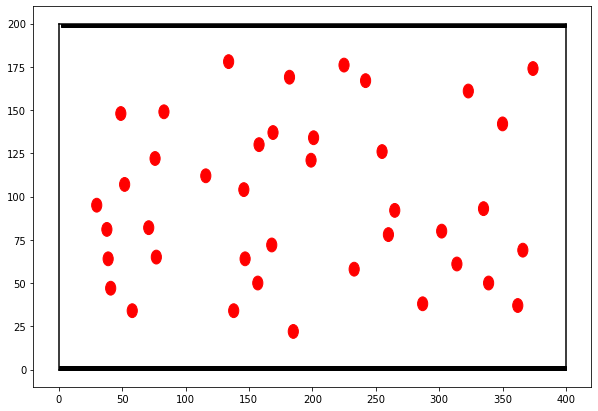

In [18]:
agents = []

agents = generate_indiv(40)

draw(exits, obstacles, size_scene, agents)

#Simulation2

In [19]:
alpha_obs , beta_obs = 10 , 0.8
alpha_obj , beta_obj = 40 , 0.8
d0 = 5  #evitement
d0_obs = 2
k = 0   #normal
K = 60  #tangentiel
K_n = 0


R = [agent.size for agent in agents]

def example_simulation():
 
    time_simulation = 10 #in seconds
    dt = .2 #in seconds
    launch_simulation(size_scene,obstacles,exits,agents,time_simulation,dt)
    
    
def launch_simulation(size_scene,obstacles,exits,agents,time_simulation,dt):
    
    history_agents = []

    for t in range(1000):
        
        patches_agents = []
        V_avant_correction = []
        P = []

        for agent in agents:

            agent.update_D_S()

            p_ext = f_motrice(agent) + f_objet(agent) + f_obstacle(agent)

            vi = agent.speed + 0.1*p_ext/agent.masse

            V_avant_correction.extend(vi)

            P.extend(p_ext)


        try:
          V_new , agents_en_chocs = correction_vitesses(V_avant_correction, P)
        except:
          print(t)
          break

        for k in range(len(agents)):
          if k not in agents_en_chocs:
            V_new[2*k] , V_new[2*k+1] = V_avant_correction[2*k] , V_avant_correction[2*k+1]

        q = predict_position2(V_new)
          

        for agent in agents: 

            k = agents.index(agent)

            agent.update_Speed([V_new[2*k] , V_new[2*k+1]])
            
            agent.update_Position(q[k])
            
            #add patch of the agent for one frame
            patches_agents.append(patches.Circle(agent.position,agent.size,color=agent.color))
 
        
        history_agents.append(patches_agents)

    
    print ('Simulation finished')
    
    display_simulation(history_agents, obstacles, exits, size_scene,dt,20)
    
def display_simulation(history_agents,obstacles, exits, size_scene,dt,speed):
    fig = plt.Figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim([0,size_scene[0]])
    ax.set_ylim([0,size_scene[1]])

    for obstacle in obstacles:
        ax.add_patch(patches.Rectangle((obstacle.position[0],obstacle.position[1]),obstacle.width,obstacle.height))

    for exit_ in exits:
        ax.add_patch(patches.Rectangle((exit_.position[0],exit_.position[1]),exit_.width,exit_.height,color='black'))
    
    def init():
        for i in range(len(history_agents)):
            for j in range(len(history_agents[i])):
                history_agents[i][j].set_visible(False)
        return []

    def animate(i):
        patches = []
        if i>0:
            for j in range(len(history_agents[i-1])):
                history_agents[i-1][j].set_visible(False)
        for j in range(len(history_agents[i])):
            history_agents[i][j].set_visible(True)
            patches.append(ax.add_patch(history_agents[i][j]))
        return patches
    
    
    #interval doesn't work
    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(history_agents), interval=dt*1000/float(speed))
    
    def save_simulation():
        print ("Saving the simulation...")
        
        # Set up formatting for the movie files
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1/float(dt)*speed, metadata=dict(artist='Me'))

        #filename = os.path.dirname(__file__)+'\Videos\simulation.mp4'
        
        anim.save('simulation.mp4', writer)
        #startfile(filename)
    
    save_simulation()
    
    print ('Simulation saved.')
    
example_simulation()

<ipython-input-11-a0f69c37ad01>:7: RuntimeWarning: invalid value encountered in true_divide
  v_ = v / numpy.linalg.norm(v)


76
Simulation finished
Saving the simulation...
Simulation saved.
